In [1]:
import numpy as np
import numdifftools as nd
from scipy import optimize
import matplotlib.pyplot as plt

from scifit.solvers import FitSolver1D

https://stackoverflow.com/questions/77719569/multivariable-gradient-descent-for-mles-nonlinear-model-in-python

In [2]:
class Model(FitSolver1D):
    @staticmethod
    def model(x, A, nu_0, alpha):
        return A * np.power((x[:, 0]/nu_0), 1. * alpha) * np.power((1 + x[:, 0]/nu_0), (-4. * alpha))

In [3]:
model = Model()

In [4]:
data = model.synthetic_dataset(xmin=0.05, xmax=1., resolution=200, parameters=(6, 2, 1), sigma=0.05, seed=12345)

In [5]:
data

,x0,y,sy,yref,ynoise
id,,,,,
1,0.050000,0.125657,0.05,0.135893,-0.010235
2,0.054774,0.171436,0.05,0.147489,0.023947
3,0.059548,0.132890,0.05,0.158862,-0.025972
4,0.064322,0.142229,0.05,0.170016,-0.027787
5,0.069095,0.279243,0.05,0.180954,0.098289
...,...,...,...,...,...
196,0.980905,0.641864,0.05,0.596315,0.045549
197,0.985678,0.544349,0.05,0.595394,-0.051045
198,0.990452,0.523796,0.05,0.594466,-0.070671


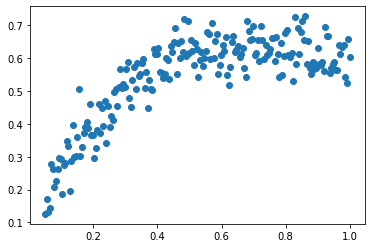

In [6]:
fig, axe = plt.subplots()
axe.scatter(data["x0"], data["y"])

In [7]:
solution = model.fit(data)
solution["parameters"]

array([5.38083692, 2.06240681, 0.95251858])

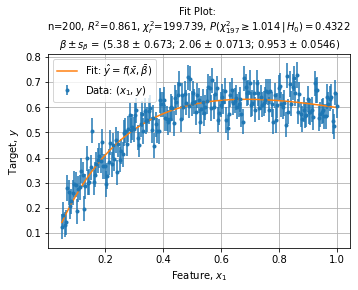

In [8]:
axe = model.plot_fit()

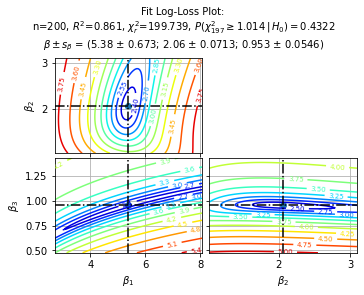

In [9]:
axe = model.plot_loss(log_loss=True)

[5.66701368 2.18827948 5.48118174]


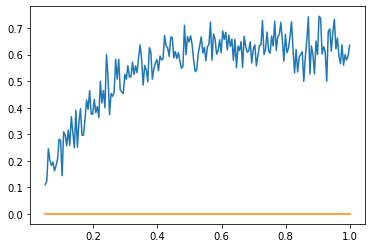

In [33]:
import numpy as np
import matplotlib.pyplot as plt

#model function s_i
def signal(A,nu_0,alpha,nu):
    return A*(nu/nu_0)**alpha*(1+nu/nu_0)**(-4*alpha)

#partial derivatives of log likelihood function
def MLE_A(A,nu_0,alpha,nu,x_i):
    nu=np.array(nu)
    x_i=np.array(x_i)
    return -np.sum(((nu/nu_0)**alpha*((A*(nu/nu_0)**alpha)/(nu/nu_0+1)**(4*alpha)-x_i))/(nu/nu_0+1)**(4*alpha))

def MLE_alpha(A,nu_0,alpha,nu,x_i):
    nu=np.array(nu)
    x_i=np.array(x_i)
    
    return -np.sum((A*(nu/nu_0)**alpha*(4*np.log(nu/nu_0+1)-np.log(nu/nu_0))*(x_i*(nu/nu_0+1)**(4*alpha)-A*(nu/nu_0)**alpha))/(nu/nu_0+1)**(8*alpha))

def MLE_nu_0(A,nu_0,alpha,nu,x_i):
    nu=np.array(nu)
    x_i=np.array(x_i)
    
    return -np.sum((A*alpha*(nu/nu_0)**(alpha)*(nu_0-3*nu)*((x_i*((nu)/nu_0+1)**(4*alpha))-A*(nu/nu_0)**alpha))/(nu_0*(nu+nu_0)*((nu)/nu_0+1)**(8*alpha)))

 
def gradient_descent(A_init,nu_0_init,alpha_init,nu,x_i,iterations=1000,learning_rate=0.01):
    
    A=A_init
    nu_0=nu_0_init
    alpha=alpha_init
    theta=np.array([A_init,nu_0_init,alpha_init])
    updated_theta=[theta]
    for i in range(iterations):
        new_theta = theta - learning_rate * np.array([MLE_A(A,nu_0,alpha,nu,x_i), MLE_nu_0(A,nu_0,alpha,nu,x_i), MLE_alpha(A,nu_0,alpha,nu,x_i)])
        theta=new_theta
        updated_theta.append(theta)
        A,nu_0,alpha = new_theta[0],new_theta[1],new_theta[2]
    return(updated_theta)

np.random.seed(1234567)
A=6
nu_0=2
alpha=1
nu=np.linspace(0.05,1.0,200)
x_i=signal(A,nu_0,alpha,nu)+np.random.normal(0,0.05,len(nu))


params= gradient_descent(A, nu_0, alpha, nu, x_i, iterations=10000, learning_rate=0.01)

print(params[-1])
A_fit=params[-1][0]
nu_0_fit=params[-1][1]
alpha_fit=params[-1][2]

plt.plot(nu,x_i)
plt.plot(nu,signal(A_fit,nu_0_fit,alpha_fit,nu))

plt.show()


In [26]:
def model(x, A, nu_0, alpha):
    return A * np.power((x/nu_0), 1. * alpha) * np.power((1 + x/nu_0), (-4. * alpha))

In [27]:
def gradient_factory(model, x, y):
    def wrapped(p):
        return 0.5 * np.sum(np.power(y - model(x, *p), 2.))
    return nd.Gradient(wrapped)

In [42]:
np.random.seed(1234567)
p0 = (6, 2, 1)
nu = np.linspace(0.05, 1.0, 200)
xi = model(nu, *p0) + 0.05 * np.random.normal(size=nu.size)

In [43]:
def gradient_descent(model, x, y, p0, tol=1e-16, maxiter=500, rate=0.001, atol=1e-10, rtol=1e-8):

    gradient = gradient_factory(model, x, y)
    
    p = np.array(p0)
    dp = gradient(p)

    for _ in range(maxiter):

        # Update gradient descent:
        p_ = p - rate * dp
        dp_ = gradient(p_)

        # Update rate:
        Dp_ = p_ - p
        Ddp_ = dp_ - dp
        rate = np.abs(Dp_.T @ Ddp_) / np.power(np.linalg.norm(Ddp_), 2)

        # Break when precision is reached:
        if np.allclose(p, p_, atol=atol, rtol=rtol):
            break

        # Next iteration:
        p = p_
        dp = dp_

    else:
        raise RuntimeError("Max Iteration (maxiter=%d) reached" % maxiter)
        
    return p

        
p = gradient_descent(model, nu, xi, [1., 1., 1.])
print(p)

[5.82733367 2.06411618 0.98227514]


In [44]:
p

array([5.82733367, 2.06411618, 0.98227514])

In [45]:
popt, pcov = optimize.curve_fit(model, nu, xi)
popt

array([5.82905928, 2.06399904, 0.98240413])

In [46]:
xhat = model(nu, *p)

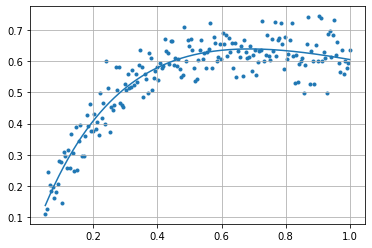

In [49]:
fig, axe = plt.subplots()
axe.scatter(nu, xi, marker=".")
axe.plot(nu, xhat)
axe.grid()